<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/NN%20AE%20EEG%20epilepsy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка библиотек

In [1]:
!pip install mne pywavelets numpy matplotlib pyedflib scipy tensorflow
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import pyedflib
import pywt
from scipy import signal
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 72.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -U -q PyDrive2
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Авторизация и создание клиента PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


## Предобработка и разделение данных

In [6]:
import mne
import numpy as np
import pywt
from sklearn.preprocessing import MinMaxScaler

common_path = '/content/drive/MyDrive/edf_process/'


# путь к файлу на гугл-диске


# ECG
#edf_path = '/content/drive/MyDrive/edf_process/ECG_example.edf'
#edf_path = '/content/drive/MyDrive/edf_process/ECGrhmn_example.edf'

# EEG_21
# 20.04.2019	19:33:06	00:45:03
# Приступ на 19:45:55, ФС с 20:10:28 по 20:12:58 и с 20:13:12 по 20:15:42 (1,2,3,8,10,15,18,20,25,30,50 Гц обе)
# Приступ на 720 секунде, ФС с 2220 секунды в течение 120 секунд и с 2400 секунды на 120 секунд
#edf_path = '/content/drive/MyDrive/edf_process/EEG_21.edf'

#EEG_85
#08.02.2020	01:54:04	08:00:00
#Приступ 2:28 и 2:43 и 3:30 и 5:49 и 5:52, ФС (1,2,3,8,10,15,18,20,25,30,50 Гц) с 7:34 по 7:36, ГВ с 7:37 по 7:40
#Приступ на 2040 секунде , ФС с 20400 секунды
#edf_path = '/content/drive/MyDrive/edf_process/EEG_85.edf'

#EEG_793
#13.01.2020	16:59:34	08:00:00
#Приступа нет, ФС (1,2,3,8,10,15,18,20,25,30,50 Гц) 18:58 по 19:01, ГВ с 19:02 по 19:07
#Приступ нет, ФС с 10710 секунды
#edf_path = '/content/drive/MyDrive/edf_process/EEG_793.edf'


#EEG_95
# 23.01.2020 12:26:50 08:00:00
# приступа нет, ФС (1,2,3,8,10,15,18,20,25,30,50 Гц) с 18:41 по 18:44, ГВ с 18:45 по 19:10
#Приступ нет, ФС с 22500 секунды
#edf_path = '/content/drive/MyDrive/edf_process/EEG_95.edf'


# EEG_28
# 12.02.2020	17:36:10	08:00:00
# Приступ 22:53, ФС (1,2,3,8,10,15,18,20,25,30,50 Гц) с 23:14 по 23:17, ГВ 23:18 по 23:24
# Приступ на 19020 секунде, ФС с 20280 секунды в течение 120 секунд
#edf_path = '/content/drive/MyDrive/edf_process/EEG_28.edf'

# Список путей к файлам EDF
file_paths = [common_path+'EEG_85.edf']

def split_data_into_chunks(data, chunk_size=256):
    num_samples, num_channels = data.shape
    chunks = [data[i:i + chunk_size] for i in range(0, num_samples - chunk_size + 1, chunk_size)]
    return np.array(chunks)

def pad_or_trim_data(data, target_length):
    """
    Приведение данных к заданной длине: либо обрезка, либо дополнение нулями.
    data имеет форму (num_windows, window_size, num_channels)
    """
    num_windows, num_samples, num_channels = data.shape
    if num_samples > target_length:
        # Обрезаем до нужной длины
        return data[:, :target_length, :]
    elif num_samples < target_length:
        # Дополняем нулями до нужной длины
        padding = np.zeros((num_windows, target_length - num_samples, num_channels))
        return np.concatenate([data, padding], axis=1)
    else:
        return data

# Пустой список для обработанных и разделенных данных
processed_and_splitted_data = []

# Обработка каждого файла
for file_path in file_paths:
    raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных

    # Удаляем последний канал
    raw_data.drop_channels([raw_data.ch_names[-1]])  # Исключаем последний канал

    # Фильтрация сигнала
    filtered_raw = raw_data.copy().filter(0.5, 50, method='fir', fir_design='firwin')

    # Получение данных с ЭЭГ каналов
    filtered_signal = filtered_raw.get_data(picks='eeg')

    # Вейвлет-преобразование
    wavelet = pywt.Wavelet('db4')
    coeffs = pywt.wavedec(filtered_signal, wavelet, level=6)
    coeffs[1:] = [pywt.threshold(i, value=0, mode='soft') if i is not None else None for i in coeffs[1:]]
    wavelet_filtered = pywt.waverec(coeffs, wavelet)

    # Проверка и дополнение нулями, если необходимо (для выравнивания длины)
    if wavelet_filtered.shape[1] < filtered_signal.shape[1]:
        diff_len = filtered_signal.shape[1] - wavelet_filtered.shape[1]
        wavelet_filtered = np.concatenate([wavelet_filtered, np.zeros((wavelet_filtered.shape[0], diff_len))], axis=1)

    # Транспонируем данные для формата (samples, channels)
    wavelet_filtered = wavelet_filtered.T

    # Нормализация данных для автоэнкодера
    #scaler = MinMaxScaler()
    #wavelet_filtered = scaler.fit_transform(wavelet_filtered)

    # Разделение данных на окна
    splitted_data = split_data_into_chunks(wavelet_filtered)

    # Добавляем обработанные и разделенные данные в список
    processed_and_splitted_data.append(splitted_data)


Extracting EDF parameters from /content/drive/MyDrive/edf_process/EEG_85.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-6-e28e1e5fd8c0>:77: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-6-e28e1e5fd8c0>:77: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-6-e28e1e5fd8c0>:77: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Reading 0 ... 3686527  =      0.000 ... 28800.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)



In [7]:
# Определите максимальное количество каналов
max_channels = max([data.shape[2] for data in processed_and_splitted_data])

def normalize_channels(data, target_channels):
    num_windows, window_size, num_channels = data.shape
    if num_channels > target_channels:
        return data[:, :, :target_channels]
    elif num_channels < target_channels:
        # Дополнить нулями до нужного количества каналов
        padding = np.zeros((num_windows, window_size, target_channels - num_channels))
        return np.concatenate([data, padding], axis=2)
    else:
        return data

# Приведение всех данных к одному количеству каналов
processed_and_splitted_data = [normalize_channels(data, max_channels) for data in processed_and_splitted_data]

# Проверка размеров после нормализации количества каналов
for i, data in enumerate(processed_and_splitted_data):
    print(f"Shape of data {i} after channel normalization: {data.shape}")

# Преобразуем список в один массив
processed_and_splitted_data = np.concatenate(processed_and_splitted_data, axis=0)


Shape of data 0 after channel normalization: (14400, 256, 8)


In [8]:
X_epi_one1 = processed_and_splitted_data
print(X_epi_one1.shape)

(14400, 256, 8)


In [12]:
from sklearn.utils import shuffle

# Если меток нет, просто перемешайте массивы
#X_epi_one = shuffle(X_epi_one1)
X_train = shuffle(X_epi_one1)

#X_test = shuffle(X_test_trimmed1)
#X_test_epi = shuffle(X_test_epi_trimmed)

print(f'Shape of X_train: {X_epi_one.shape}')
#print(f'Shape of X_test: {X_test.shape}')
#print(f'Shape of X_test_epi: {X_test_epi.shape}')

Shape of X_train: (14400, 256, 8)


## Autoencoder

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout, BatchNormalization
import matplotlib.pyplot as plt

# Убедитесь, что window_size совпадает с размером окна, которое вы использовали в данных (например, 128)
window_size = 256
num_channels = 8  # Количество каналов данных ЭЭГ

# Определение автоэнкодера для данных с 24 каналов
input_shape = (window_size, num_channels)

model = Sequential([
    Flatten(input_shape=input_shape),  # Преобразуем в одномерный вектор
    Dense(128, activation='relu'),    # Убираем активацию из слоя
    #LeakyReLU(alpha=0.01), # Добавляем LeakyReLU с параметром alpha (наклон)
    #Dropout(0.3),
    Dense(64, activation='relu'),
    #Dropout(0.3),
    #BatchNormalization(),
    Dense(32, activation='relu'),

    Dense(16, activation='relu'),  # bottleneck

    Dense(32, activation='relu'),
    #Dropout(0.3),
    Dense(64, activation='relu'),
    #LeakyReLU(alpha=0.01),
    #Dropout(0.3),
    #BatchNormalization(),
    Dense(128, activation='relu'),
    Dense(window_size * num_channels),  # Выходной слой
    Reshape(input_shape)            # Восстановление исходной формы (window_size, num_channels)
])

# Компиляция модели
optimizer = Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 16)                528       
                                                                 
 dense_12 (Dense)            (None, 32)                544       
                                                                 
 dense_13 (Dense)            (None, 64)               

In [16]:
# Обучение автоэнкодера
# Обучение модели
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

early_stopping = EarlyStopping(
    monitor='val_loss',   # Используем валидационную ошибку для мониторинга
    patience=5,           # Остановиться, если ошибка не уменьшается 5 эпох подряд
    restore_best_weights=True  # Восстановить веса с наименьшей ошибкой
)
import tensorflow as tf
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

# Включение TensorBoard в процессе обучения
history = model.fit(
    X_train, X_train,
    validation_split = 0.3,
    batch_size = 128,
    epochs=50,
    callbacks=[early_stopping, tensorboard_callback]
)



Epoch 1/50
79/79 [==============================] - 1s 13ms/step - loss: 3.5253e-10 - val_loss: 3.3911e-10
Epoch 2/50
79/79 [==============================] - 1s 10ms/step - loss: 3.5271e-10 - val_loss: 3.3894e-10
Epoch 3/50
79/79 [==============================] - 1s 10ms/step - loss: 3.5263e-10 - val_loss: 3.3904e-10
Epoch 4/50
79/79 [==============================] - 1s 10ms/step - loss: 3.5258e-10 - val_loss: 3.3876e-10
Epoch 5/50
79/79 [==============================] - 1s 10ms/step - loss: 3.5252e-10 - val_loss: 3.3927e-10
Epoch 6/50
79/79 [==============================] - 1s 10ms/step - loss: 3.5265e-10 - val_loss: 3.3922e-10
Epoch 7/50
79/79 [==============================] - 1s 10ms/step - loss: 3.5251e-10 - val_loss: 3.3886e-10
Epoch 8/50
79/79 [==============================] - 1s 11ms/step - loss: 3.5260e-10 - val_loss: 3.3934e-10
Epoch 9/50
79/79 [==============================] - 1s 10ms/step - loss: 3.5261e-10 - val_loss: 3.3923e-10


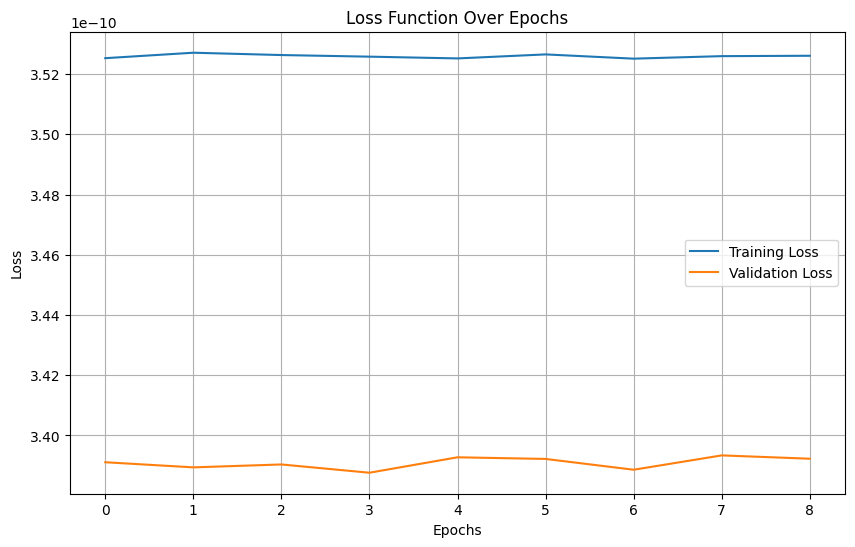

In [17]:
import matplotlib.pyplot as plt

# Визуализация функции потерь на обучении и валидации
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Прогнозирование данных для сравнения
X_test_pred = model.predict(X_train)


450/450 [==============================] - 1s 2ms/step


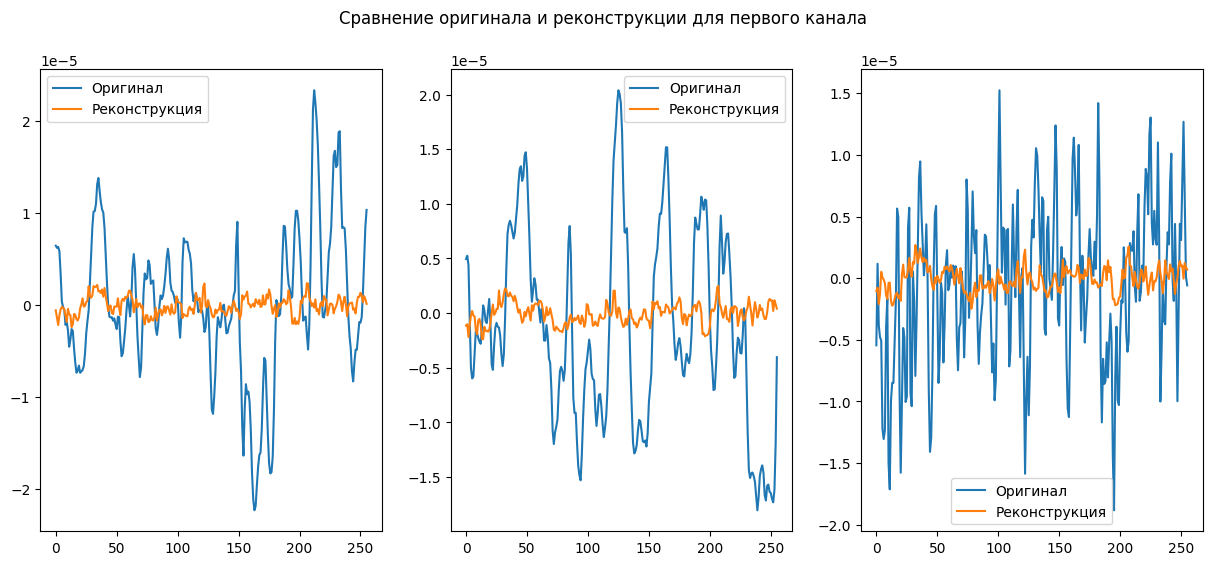

In [19]:
# Визуализация: сравнение исходных данных и их реконструкции для первого канала
num_examples = 3  # Количество примеров для визуализации
plt.figure(figsize=(15,6))

for i in range(num_examples):
    plt.subplot(1, num_examples, i+1)
    plt.plot(X_train[i, :, 3], label='Оригинал')  # Данные с первого канала
    plt.plot(X_test_pred[i, :, 3], label='Реконструкция')  # Реконструкция первого канала
    plt.legend()

plt.suptitle('Сравнение оригинала и реконструкции для первого канала')
plt.show()


## TRC

## Обработка

In [ ]:
!pip install micromed_io

In [ ]:
# Путь к директории с файлами .TRC
data_path = '/content/drive/MyDrive/eeg/epileptic/'

In [ ]:
from micromed_io.trc import MicromedTRC

def check_trc_file(file_path):
    try:
        mmtrc = MicromedTRC(file_path)
        data = mmtrc.get_data()
        sfreq = mmtrc.get_sfreq()

        # Проверка типа данных и их формы
        print(f"Data type: {type(data)}")
        print(f"Data shape: {data.shape}")
        print(f"Sampling frequency: {sfreq}")

        if isinstance(data, np.ndarray) and len(data.shape) == 2:
            num_channels, num_samples = data.shape
            print(f"Number of channels: {num_channels}")
            print(f"Number of samples: {num_samples}")

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")


check_trc_file('/content/drive/MyDrive/eeg/epileptic/EEG_177.TRC')


Data type: <class 'numpy.ndarray'>
Data shape: (27, 260)
Sampling frequency: 128
Number of channels: 27
Number of samples: 260


In [ ]:
import numpy as np
import pywt
from micromed_io.trc import MicromedTRC
import mne
import os

def filter_and_wavelet_transform(signal, sfreq):
    # Фильтрация сигнала
    filtered_signal = mne.filter.filter_data(signal, sfreq=sfreq, l_freq=0.5, h_freq=50, method='fir', fir_design='firwin')

    # Вейвлет-преобразование
    wavelet = pywt.Wavelet('db4')
    coeffs = pywt.wavedec(filtered_signal, wavelet, level=6)
    coeffs[1:] = [pywt.threshold(i, value=0, mode='soft') if i is not None else None for i in coeffs[1:]]
    wavelet_filtered = pywt.waverec(coeffs, wavelet)

    return wavelet_filtered

def split_data_into_chunks(data, chunk_size=256):
    num_channels, num_samples = data.shape
    chunks = []

    for channel in range(num_channels):
        channel_data = data[channel]
        num_chunks = (num_samples + chunk_size - 1) // chunk_size  # Calculate number of chunks
        padded_length = num_chunks * chunk_size
        padded_data = np.pad(channel_data, (0, padded_length - num_samples), mode='constant')
        channel_chunks = [padded_data[i:i + chunk_size] for i in range(0, padded_length, chunk_size)]
        chunks.append(channel_chunks)

    return np.array(chunks)

def process_trc_file(file_path, chunk_size=256):
    mmtrc = MicromedTRC(file_path)

    # Получение данных и частоты дискретизации
    data = mmtrc.get_data()
    sfreq = mmtrc.get_sfreq()  # Проверьте, как правильно извлечь частоту дискретизации из заголовка

    if isinstance(data, np.ndarray) and len(data.shape) == 2:
        num_channels, num_samples = data.shape
    else:
        raise ValueError("Data is not in expected format. Expected 2D array.")

    # Фильтрация и вейвлет-преобразование
    processed_signals = []
    for channel in range(num_channels):
        processed_signal = filter_and_wavelet_transform(data[channel], sfreq)
        processed_signal = np.pad(processed_signal, (0, max(0, num_samples - len(processed_signal))), mode='constant')
        processed_signals.append(processed_signal)

    processed_signals = np.array(processed_signals)

    # Разделение на окна
    split_signals = split_data_into_chunks(processed_signals, chunk_size)

    # Переставляем размерности для автоэнкодера
    split_signals = np.transpose(split_signals, (1, 2, 0))  # Переставляем в форму (количество_окон, размер_окна, количество_каналов)

    return split_signals

# Путь к директории с файлами .TRC
common_path_trc = '/content/drive/MyDrive/eeg/epileptic/'

# Получение списка всех файлов в директории
file_paths_TRC = [os.path.join(common_path_trc, f) for f in os.listdir(common_path_trc) if f.endswith('.TRC')]

# Список для хранения обработанных данных
all_processed_data = []
expected_num_channels = None

# Цикл обработки всех файлов
for file_path in file_paths_TRC:
    try:
        print(f'Processing file: {file_path}')

        # Обрабатываем файл
        processed_data = process_trc_file(file_path)

        # Проверка и согласование количества каналов
        num_channels = processed_data.shape[2]
        if expected_num_channels is None:
            expected_num_channels = num_channels
        elif num_channels != expected_num_channels:
            print(f'Channel mismatch detected in file: {file_path}')

            if num_channels < expected_num_channels:
                # Дополняем отсутствующие каналы нулями
                padding_channels = expected_num_channels - num_channels
                padding_shape = ((0, 0), (0, 0), (0, padding_channels))  # Дополняем последнюю ось (каналы)
                processed_data = np.pad(processed_data, padding_shape, mode='constant')
                print(f'File {file_path} padded to {expected_num_channels} channels.')
            else:
                print(f'Skipping file {file_path} due to more channels than expected.')
                continue

        # Добавляем обработанные данные в общий список
        all_processed_data.append(processed_data)

        print(f'Successfully processed: {file_path}')

    except Exception as e:
        print(f'Error processing file {file_path}: {e}')



Processing file: /content/drive/MyDrive/eeg/epileptic/EEG_177.TRC
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)

Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper 

<ipython-input-543-2951da18391c>:9: RuntimeWarning: filter_length (845) is longer than the signal (260), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_signal = mne.filter.filter_data(signal, sfreq=sfreq, l_freq=0.5, h_freq=50, method='fir', fir_design='firwin')
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(
<ipython-input-543-2951da18391c>:9: RuntimeWarning: filter_length (845) is longer than the signal (260), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_signal = mne.filter.filter_data(signal, sfreq=sfreq, l_freq=0.5, h_freq=50, method='fir', fir_design='firwin')
<ipython-input-543-2951da18391c>:9: RuntimeWarning: filter_length (845) is longer than the signal (260), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_signal = mne.filter.filter_data(signal, sfreq


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)

Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)

Setti

<ipython-input-543-2951da18391c>:9: RuntimeWarning: filter_length (845) is longer than the signal (260), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_signal = mne.filter.filter_data(signal, sfreq=sfreq, l_freq=0.5, h_freq=50, method='fir', fir_design='firwin')
<ipython-input-543-2951da18391c>:9: RuntimeWarning: filter_length (845) is longer than the signal (260), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_signal = mne.filter.filter_data(signal, sfreq=sfreq, l_freq=0.5, h_freq=50, method='fir', fir_design='firwin')
<ipython-input-543-2951da18391c>:9: RuntimeWarning: filter_length (845) is longer than the signal (260), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_signal = mne.filter.filter_data(signal, sfreq=sfreq, l_freq=0.5, h_freq=50, method='fir', fir_design='firwin')
<ipython-input-543-2951da18391c>:9: RuntimeWarning: filter_length (845) is longer than the signal (260), dist

Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)

Successfully processed: /content/drive/MyDrive/eeg/epileptic/EEG_177.TRC


<ipython-input-543-2951da18391c>:9: RuntimeWarning: filter_length (845) is longer than the signal (260), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_signal = mne.filter.filter_data(signal, sfreq=sfreq, l_freq=0.5, h_freq=50, method='fir', fir_design='firwin')
<ipython-input-543-2951da18391c>:9: RuntimeWarning: filter_length (845) is longer than the signal (260), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_signal = mne.filter.filter_data(signal, sfreq=sfreq, l_freq=0.5, h_freq=50, method='fir', fir_design='firwin')


In [ ]:
for i, data in enumerate(all_processed_data):
    print(f'Data {i} shape: {data.shape}')


Data 0 shape: (2, 256, 27)


In [ ]:
# Проверяем, есть ли данные для объединения
if all_processed_data:
    # Объединяем данные по оси 0 (по количеству окон)
    all_processed_data = np.concatenate(all_processed_data, axis=0)
    print(f'Combined data shape: {all_processed_data.shape}')
else:
    print("No processed data to combine.")


Combined data shape: (2, 256, 27)


In [ ]:
    # Сохраняем объединенные данные в файл
    np.save('/content/drive/MyDrive/eeg/epileptic/epi_data_test.npy', all_processed_data)
    print('Combined data saved')



Combined data saved


## загрузка

In [ ]:
# Загрузка данных
X_train1 = np.load('/content/drive/MyDrive/eeg/healthy/data_train_shuffled.npy')
X_test1 = np.load('/content/drive/MyDrive/eeg/healthy/data_test_shuffled.npy')
X_test_epi1 = np.load('/content/drive/MyDrive/eeg/healthy/data_epi_shuffled.npy')
#X_train1 = all_processed_data
# Проверка формы данных
print(f'Shape of X_train: {X_train1.shape}')
print(f'Shape of X_test: {X_test1.shape}')
print(f'Shape of X_test_epi: {X_test_epi1.shape}')


Shape of X_train: (135732, 256, 27)
Shape of X_test: (5346, 256, 27)
Shape of X_test_epi: (61783, 256, 27)


In [ ]:
# Проверка данных на наличие NaN или inf
print(np.isnan(X_train1).any())  # True если есть NaN
print(np.isinf(X_train1).any())  # True если есть inf


In [ ]:
# Проверка данных на наличие NaN или inf
print(np.isnan(X_test1).any())  # True если есть NaN
print(np.isinf(X_test1).any())  # True если есть inf


False
False


In [ ]:
# Удаляем выборки, содержащие хотя бы одно NaN
#X_train1_clean = X_train1[~np.isnan(X_train1).any(axis=(1, 2))]

#print(f"Исходная форма данных: {X_train1.shape}")
#print(f"Форма данных без NaN: {X_train1_clean.shape}")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    num_samples, num_windows, num_channels = data.shape
    data_reshaped = data.reshape(-1, num_channels)  # Преобразуем в двумерный массив для нормализации
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data_reshaped)
    return normalized_data.reshape(num_samples, num_windows, num_channels)

# Нормализация данных
#X_train_normalized1 = normalize_data(X_train1)
#X_test_normalized1 = normalize_data(X_test1)
X_test_epi_normalized = normalize_data(all_processed_data)

#print(f'Shape of X_train_normalized: {X_train_normalized1.shape}')
#print(f'Shape of X_test_normalized: {X_test_normalized1.shape}')
print(f'Shape of X_test_epi_normalized: {X_test_epi_normalized.shape}')


Shape of X_test_epi_normalized: (2, 256, 27)


In [ ]:
# Определение минимального количество каналов
#num_channels = min(X_train_normalized1.shape[2], X_test_normalized1.shape[2], X_test_epi_normalized.shape[2])
num_channels = 27
# Обрезка данных до минимального количества каналов
#X_train_trimmed1 = X_train_normalized1[:, :, :num_channels]
#X_test_trimmed1 = X_test_normalized1[:, :, :num_channels]
X_test_epi_trimmed = X_test_epi_normalized[:, :, :num_channels]

#print(f'Shape of trimmed X_train: {X_train_trimmed1.shape}')
#print(f'Shape of trimmed X_test: {X_test_trimmed1.shape}')
print(f'Shape of trimmed X_test_epi: {X_test_epi_trimmed.shape}')


Shape of trimmed X_test_epi: (2, 256, 27)


In [ ]:
X_EEG_177_e = X_test_epi_trimmed

In [ ]:
#print(f'Shape of X_train: {X_train_normalized1.shape}')
#print(f'Shape of X_test: {X_test_normalized1.shape}')
print(f'Shape of X_test_epi_normalized: {X_test_epi_normalized.shape}')

# Проверка уникального количества каналов
#unique_channels_train = np.unique(X_train_normalized1.shape[2])
#unique_channels_test = np.unique(X_test_normalized1.shape[2])
unique_channels_epi_test = np.unique(X_test_epi_normalized.shape[2])

print(f'Unique number of channels in X_train: {unique_channels_train}')
print(f'Unique number of channels in X_test: {unique_channels_test}')
print(f'Unique number of channels in X_test_epi: {unique_channels_epi_test}')


Shape of X_test_epi_normalized: (11756, 256, 27)
Unique number of channels in X_train: [28]
Unique number of channels in X_test: [27]
Unique number of channels in X_test_epi: [27]


In [ ]:
from sklearn.utils import shuffle

# Если меток нет, просто перемешайте массивы
#X_train = shuffle(X_train_trimmed1)
#X_test = shuffle(X_test_trimmed1)
X_test_epi = shuffle(X_test_epi_trimmed)

#print(f'Shape of X_train: {X_train.shape}')
#print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of X_test_epi: {X_test_epi.shape}')

Shape of X_test_epi: (61783, 256, 27)


In [ ]:
import numpy as np
# Сохраняем объединенные данные в файл
np.save('/content/drive/MyDrive/eeg/healthy/data_epi_shuffled.npy', X_test_epi)
print('Combined data saved')

Combined data saved


## Модель и обучение

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras import losses
from tensorflow.keras.initializers import HeNormal

window_size = 256
num_channels = 27  # Количество каналов данных ЭЭГ

# Определение автоэнкодера
input_shape = (window_size, num_channels)

model1 = Sequential([
    Flatten(input_shape=input_shape),  # Преобразуем в одномерный вектор
    Dropout(0.2),
    Dense(512, activation='relu', kernel_initializer=HeNormal()),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),    # Убираем активацию из слоя
    #LeakyReLU(alpha=0.01), # Добавляем LeakyReLU с параметром alpha (наклон)
    #Dropout(0.2),
    Dense(64, activation='relu'),
    #BatchNormalization(),

    Dense(32, activation='relu', use_bias=False),  # bottleneck

    Dense(64, activation='relu'),
    #Dropout(0.3),
    #BatchNormalization(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.2),
    #LeakyReLU(alpha=0.01),
    Dense(window_size*num_channels),  # Выходной слой
    Reshape(input_shape)            # Восстановление исходной формы (window_size, num_channels)
])

# Компиляция модели
#optimizer = Adam(learning_rate = 0.0001)
model1.compile(optimizer='adam', loss='mse')
model1.summary()


Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_55 (Flatten)        (None, 6912)              0         
                                                                 
 dropout_94 (Dropout)        (None, 6912)              0         
                                                                 
 dense_361 (Dense)           (None, 512)               3539456   
                                                                 
 dense_362 (Dense)           (None, 256)               131328    
                                                                 
 dense_363 (Dense)           (None, 128)               32896     
                                                                 
 dense_364 (Dense)           (None, 64)                8256      
                                                                 
 dense_365 (Dense)           (None, 32)              

In [ ]:
# Обучение модели
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

early_stopping = EarlyStopping(
    monitor='val_loss',   # Используем валидационную ошибку для мониторинга
    patience=5,           # Остановиться, если ошибка не уменьшается 5 эпох подряд
    restore_best_weights=True  # Восстановить веса с наименьшей ошибкой
)
import tensorflow as tf
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

# Включение TensorBoard в процессе обучения
history1 = model1.fit(
    X_train1, X_train1,
    validation_split = 0.3,
    batch_size = 128,
    epochs=50,
    callbacks=[early_stopping, tensorboard_callback]
)


#history1 = model1.fit(X_train_trimmed1, X_train_trimmed1, epochs=20, batch_size=32, validation_split=0.3)


Epoch 1/50
743/743 [==============================] - 29s 37ms/step - loss: 0.0034 - val_loss: 7.6313e-05
Epoch 2/50
743/743 [==============================] - 23s 31ms/step - loss: 5.4540e-04 - val_loss: 1.5092e-04
Epoch 3/50
743/743 [==============================] - 23s 32ms/step - loss: 3.7412e-04 - val_loss: 2.0728e-04
Epoch 4/50
743/743 [==============================] - 23s 31ms/step - loss: 2.9661e-04 - val_loss: 9.1237e-05
Epoch 5/50
743/743 [==============================] - 23s 31ms/step - loss: 2.3935e-04 - val_loss: 6.4847e-05
Epoch 6/50
743/743 [==============================] - 23s 31ms/step - loss: 1.9080e-04 - val_loss: 6.9832e-05
Epoch 7/50
743/743 [==============================] - 23s 31ms/step - loss: 1.5453e-04 - val_loss: 7.2202e-05
Epoch 8/50
743/743 [==============================] - 23s 31ms/step - loss: 1.2565e-04 - val_loss: 7.1466e-05
Epoch 9/50
743/743 [==============================] - 23s 31ms/step - loss: 1.0348e-04 - val_loss: 6.5046e-05
Epoch 10/50
74

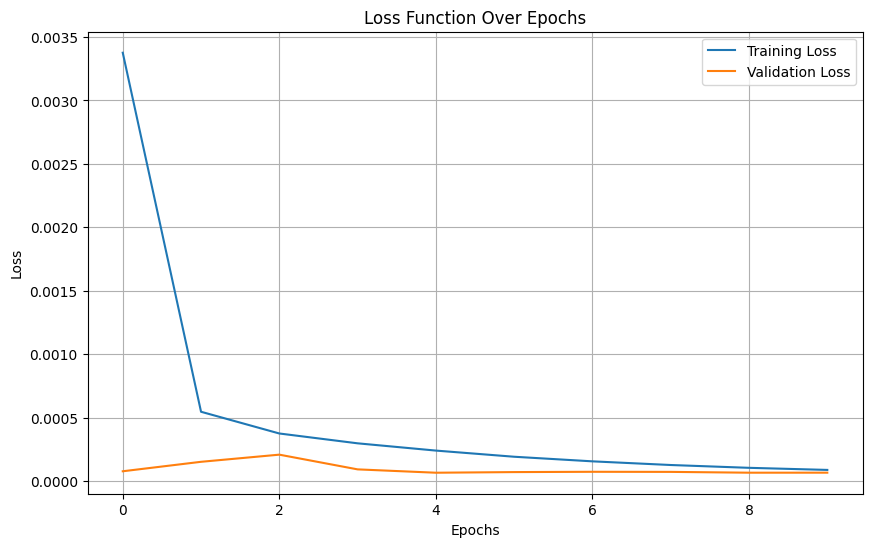

In [ ]:
import matplotlib.pyplot as plt

# Визуализация функции потерь на обучении и валидации
plt.figure(figsize=(10, 6))
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
#plt.plot(history1.history['mse'], label='MSE')
#plt.plot(history1.history['val_mse'], label='Validation MSE')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout, Reshape, LeakyReLU, ELU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Параметры
window_size = 256
num_channels = 27  # Количество каналов данных ЭЭГ
epochs = 20
batch_size = 128

# Пример данных (замените на ваши данные)
# X_train должен быть формата (число образцов, window_size, num_channels)
X_train = X_train1  # Замените на ваши данные


In [ ]:
# Функция для создания автоэнкодера с конкретной функцией активации
def create_autoencoder(activation_function):
    model = Sequential([
        Flatten(input_shape=(window_size, num_channels)),
        Dropout(0.2),
        Dense(512, activation=activation_function, kernel_initializer=HeNormal()),
        Dense(256, activation=activation_function),
        Dense(128, activation=activation_function),
        Dense(64, activation=activation_function),  # bottleneck
        Dense(128, activation=activation_function),
        Dense(256, activation=activation_function),
        Dense(512, activation=activation_function),
        Dropout(0.2),
        Dense(window_size * num_channels),  # Выходной слой
        Reshape((window_size, num_channels))  # Восстановление исходной формы
    ])

    # Компиляция модели
    optimizer1 = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer1, loss='mse')
    return model


In [ ]:
# Словарь для хранения моделей и их истории обучения
activations = ['relu', 'leaky_relu', 'elu']
models = {}
histories = {}

# Определяем раннюю остановку
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for activation in activations:
    print(f"Обучение модели с активацией {activation}...")

    # Создание модели с конкретной функцией активации
    if activation == 'leaky_relu':
        model = create_autoencoder(activation_function=LeakyReLU(alpha=0.01))
    elif activation == 'elu':
        model = create_autoencoder(activation_function=ELU(alpha=1.0))  # Объект ELU
    else:
        model = create_autoencoder(activation_function=tf.keras.activations.relu)  # Функция relu из tensorflow

    # Обучение модели с отображением потерь
    history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.3, verbose=1, callbacks=[early_stopping])
    models[activation] = model
    histories[activation] = history


Обучение модели с активацией relu...
Epoch 1/20
743/743 [==============================] - 28s 36ms/step - loss: 0.0079 - val_loss: 2.3712e-04
Epoch 2/20
743/743 [==============================] - 22s 29ms/step - loss: 0.0010 - val_loss: 2.0564e-04
Epoch 3/20
743/743 [==============================] - 22s 29ms/step - loss: 7.6779e-04 - val_loss: 1.7860e-04
Epoch 4/20
743/743 [==============================] - 22s 29ms/step - loss: 6.4361e-04 - val_loss: 6.3550e-05
Epoch 5/20
743/743 [==============================] - 22s 29ms/step - loss: 5.5132e-04 - val_loss: 8.0280e-05
Epoch 6/20
743/743 [==============================] - 22s 30ms/step - loss: 4.8380e-04 - val_loss: 1.0536e-04
Epoch 7/20
743/743 [==============================] - 22s 29ms/step - loss: 4.3344e-04 - val_loss: 7.1305e-05
Epoch 8/20
743/743 [==============================] - 22s 29ms/step - loss: 3.8263e-04 - val_loss: 6.3851e-05
Epoch 9/20
743/743 [==============================] - 22s 29ms/step - loss: 3.4540e-04 - va

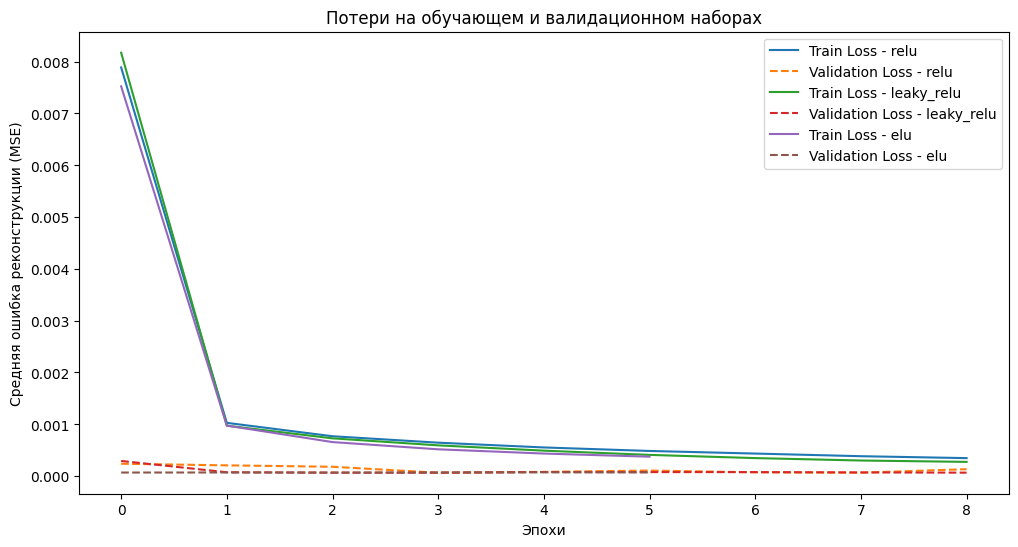

In [ ]:
# Визуализация результатов обучения
plt.figure(figsize=(12, 6))

for activation in activations:
    plt.plot(histories[activation].history['loss'], label=f'Train Loss - {activation}')
    plt.plot(histories[activation].history['val_loss'], label=f'Validation Loss - {activation}', linestyle='--')

plt.title('Потери на обучающем и валидационном наборах')
plt.xlabel('Эпохи')
plt.ylabel('Средняя ошибка реконструкции (MSE)')
plt.legend()
plt.show()


In [ ]:
# Прогнозирование и оценка
X_test_pred1 = model1.predict(X_test1)


168/168 [==============================] - 0s 2ms/step


## классификация

In [ ]:
import numpy as np

# Применение автоэнкодера для получения реконструированных сигналов
reconstructed_signals = model1.predict(X_EEG_1_e)

# Вычисление ошибки реконструкции (среднеквадратичная ошибка - MSE для каждого окна)
reconstruction_errors = np.mean((X_EEG_1_e - reconstructed_signals) ** 2, axis=(1, 2))

# Пороговое значение для определения аномалий
mu = np.mean(reconstruction_errors)
sigma = np.std(reconstruction_errors)
threshold = mu + 2 * sigma  # Порог для аномалий (можно варьировать коэффициент 10)

print(f"Средняя ошибка реконструкции: {mu:.5f}")
print(f"Стандартное отклонение ошибки: {sigma:.5f}")
print(f"Пороговое значение: {threshold:.5f}")

# Классификация аномалий
anomalies = reconstruction_errors > threshold

# Подсчет количества аномальных окон
anomalous_windows = np.sum(anomalies)

# Общее количество окон
total_windows = len(reconstruction_errors)

# Вычисление процентного соотношения аномальных окон
anomalous_percentage = (anomalous_windows / total_windows) * 100

print(f"Общее количество окон: {total_windows}")
print(f"Количество аномальных окон: {anomalous_windows}")
print(f"Процент аномальных окон: {anomalous_percentage:.2f}%")
# Классификация в зависимости от процентного содержания аномальных окон

if anomalous_percentage > 0.9:
    classification = "эпилептические"
else:
    classification = "здоровые"

print(f"Процент аномальных окон в эпилептических данных: {anomalous_percentage:.2f}%")
print(f"Классификация: {classification}")

288/288 [==============================] - 1s 3ms/step
Средняя ошибка реконструкции: 0.00505
Стандартное отклонение ошибки: 0.00283
Пороговое значение: 0.01071
Общее количество окон: 9192
Количество аномальных окон: 217
Процент аномальных окон: 2.36%
Процент аномальных окон в эпилептических данных: 2.36%
Классификация: эпилептические


In [ ]:
# Ошибка на обучающих данных
train_reconstructed = model1.predict(X_train1)
train_errors = np.mean((X_train1 - train_reconstructed) ** 2, axis=(1, 2))
train_mean_error = np.mean(train_errors)
train_std_error = np.std(train_errors)

print(f"Средняя ошибка на обучении: {train_mean_error:.5f}")

# Установка порога для аномалий
threshold = train_mean_error + 4*train_std_error
print(f"Порог для аномалий: {threshold:.5f}")


4242/4242 [==============================] - 20s 5ms/step
Средняя ошибка на обучении: 0.00007
Порог для аномалий: 0.00349


In [ ]:
# Рассчитаем среднюю мощность сигнала для каждого окна
mean_powers = np.mean(X_EEG_177_e ** 2, axis=(1, 2))

# Порог на основе средней мощности
threshold = np.mean(mean_powers) + 2 * np.std(mean_powers)

# Классификация на основе энергии сигнала
anomalies = mean_powers > threshold

In [ ]:
reconstructed_epileptic = model1.predict(X_test_epi)
error_epileptic = np.mean(np.abs(reconstructed_epileptic - X_test_epi), axis=1)


1931/1931 [==============================] - 5s 3ms/step


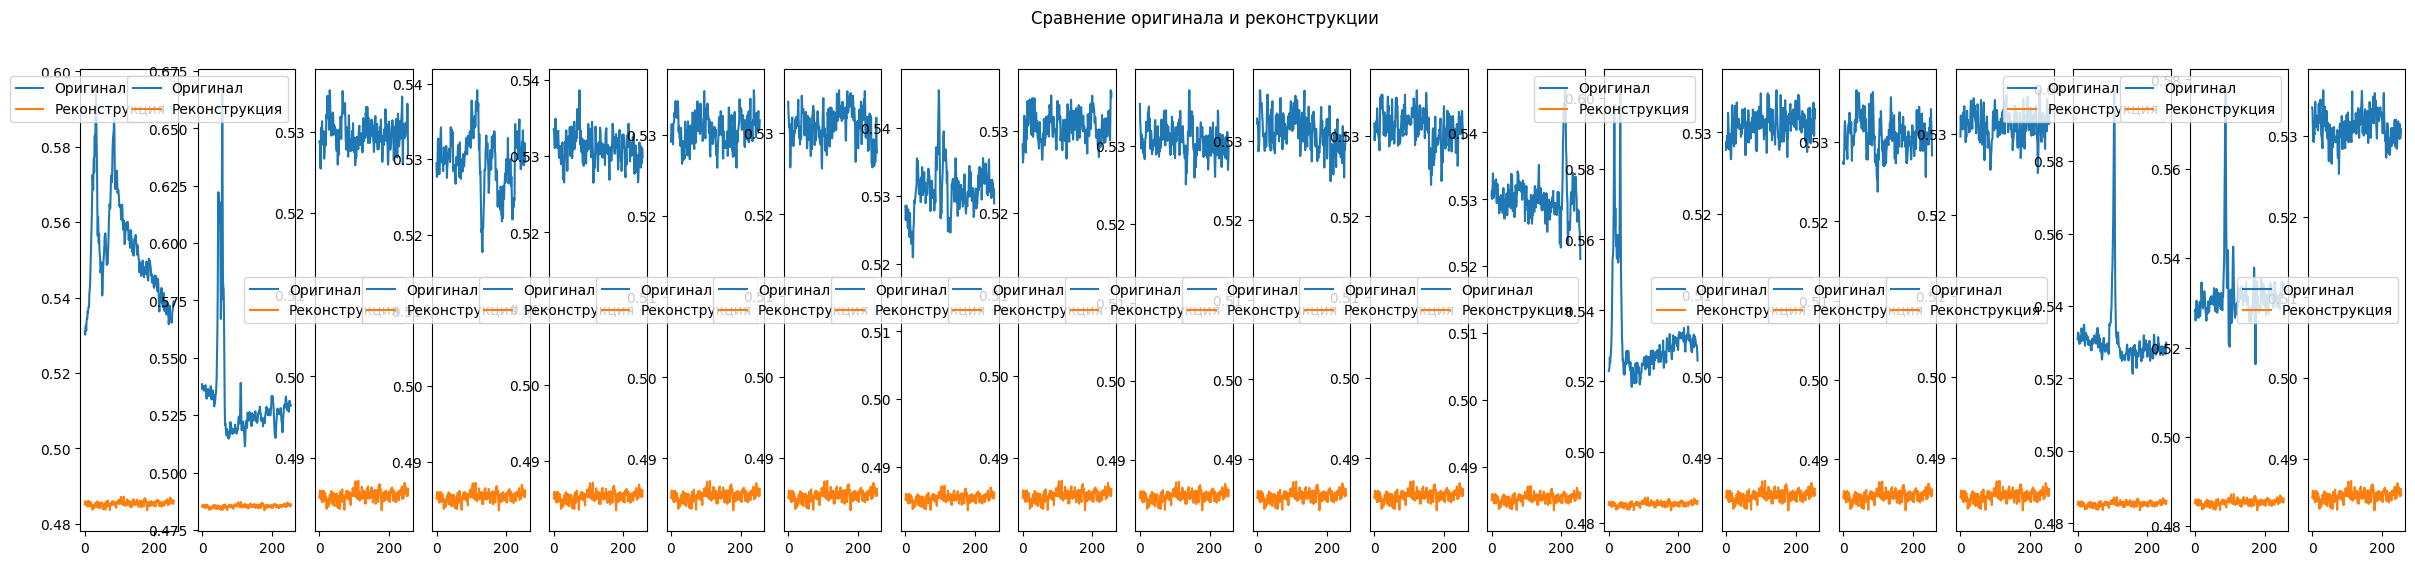

In [ ]:
# Визуализация
import matplotlib.pyplot as plt

num_examples = 20
plt.figure(figsize=(30,6))

for i in range(num_examples):
    plt.subplot(1, num_examples, i+1)
    plt.plot(X_EEG_2_e[i, :, 1], label='Оригинал')
    plt.plot(test_reconstructed[i, :, 1], label='Реконструкция')
    plt.legend()

plt.suptitle('Сравнение оригинала и реконструкции')
plt.show()

In [ ]:
# Сохранение модели в формате
model1.save('my_model2.keras')

In [ ]:
from google.colab import files
files.download('my_model2.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(reconstructed_signals.shape)
print(X_test_epi1.shape)

(61783, 256, 27)
(61783, 256, 27)


In [ ]:
reconstructed_signals_reshaped = reconstructed_signals.reshape(-1, 27)
X_test_epi1_reshaped = X_test_epi1.reshape(-1, 27)
print(reconstructed_signals_reshaped.shape)
print(X_test_epi1_reshaped.shape)

(15816448, 27)
(15816448, 27)


In [ ]:
X_epi = np.load('/content/drive/MyDrive/eeg/epileptic/epi_data_test.npy')

In [ ]:
X_epi_norm = normalize_data(X_epi)

In [ ]:
X_pred_epi = model1.predict(X_epi_norm)

1931/1931 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


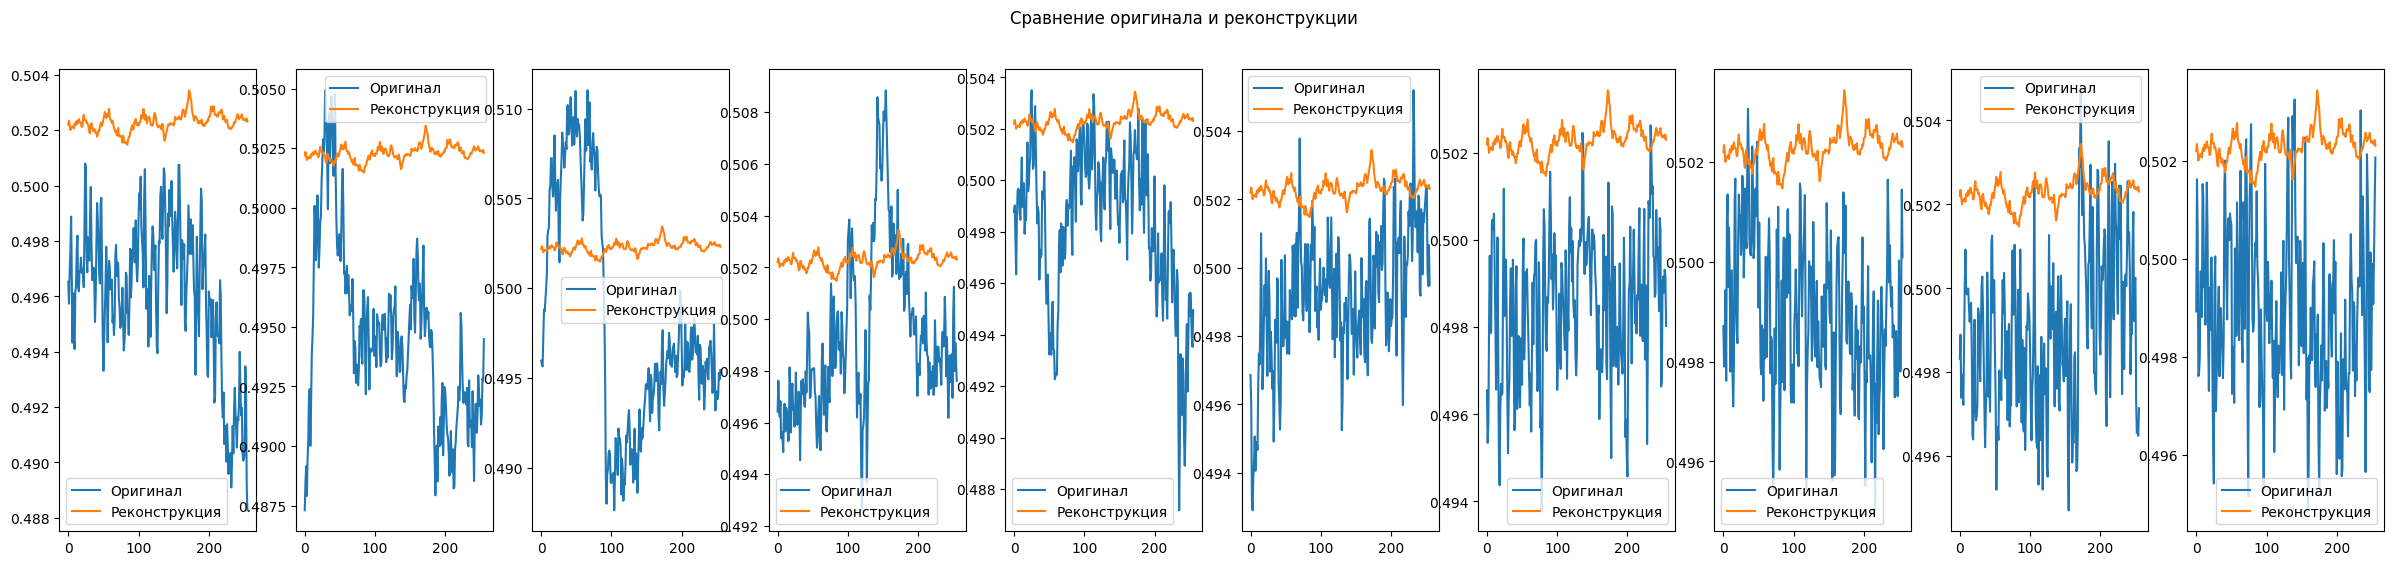

In [ ]:
# Визуализация
import matplotlib.pyplot as plt

num_examples = 10
plt.figure(figsize=(30,6))

for i in range(num_examples):
    plt.subplot(1, num_examples, i+1)
    plt.plot(X_epi_norm[i+3, :, 6], label='Оригинал')
    plt.plot(X_pred_epi[i+3, :, 6], label='Реконструкция')
    plt.legend()

plt.suptitle('Сравнение оригинала и реконструкции')
plt.show()

## Оценка точности и специфичности

In [ ]:
# Результаты классификации
results = {
    "EEG_1.TRC": (1, 1),  # (файл, метка) - 1 = эпилептический
    "EEG_2.TRC": (1, 0),
    "EEG_3.TRC": (1, 1),
    "EEG_4.TRC": (1, 0),
    "EEG_6.TRC": (1, 0),
    "EEG_177.TRC": (1, 1),

    "EEG_47.TRC": (0, 0),  # 0 = здоровый
    "EEG_24.TRC": (0, 1),  # неправильно классифицированный
    "EEG_112.TRC": (0, 1),
    "EEG_149.TRC": (0, 1),  # неправильно классифицированный
    "EEG_109.TRC": (0, 1),
    "EEG_69.TRC": (0, 1)
     # неправильно классифицированный
}

# Инициализация счетчиков
TP = TN = FP = FN = 0

# Подсчет TP, TN, FP и FN
for file, (true_label, predicted_label) in results.items():
    if true_label == 1 and predicted_label == 1:
        TP += 1  # Истинно положительные
    elif true_label == 0 and predicted_label == 0:
        TN += 1  # Истинно отрицательные
    elif true_label == 0 and predicted_label == 1:
        FP += 1  # Ложно положительные
    elif true_label == 1 and predicted_label == 0:
        FN += 1  # Ложно отрицательные

print(f'TP = ', TP)
print(f'TN = ', TN)
print(f'FP = ', FP)
print(f'FN = ', FN)
# Расчет точности и специфичности
accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Избегаем деления на ноль
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
balanced_acc = (specificity + sensitivity)/2
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1=2*precision*recall/(precision+recall)
# Вывод результатов
print(f"Точность модели (accur.): {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"Специфичность модели: {specificity:.4f} ({specificity * 100:.2f}%)")
print(f"Чувствительность модели: {sensitivity:.4f} ({sensitivity * 100:.2f}%)")
print(f"сбал. точность: {balanced_acc:.4f} ({balanced_acc * 100:.2f}%)")
print(f"пресижн точность: {precision:.4f} ({precision * 100:.2f}%)")
print(f"полнота: {recall:.4f} ({recall * 100:.2f}%)")
print(f"F1-score: {f1:.4f} ({f1 * 100:.2f}%)")


TP =  3
TN =  1
FP =  5
FN =  3
Точность модели (accur.): 0.3333 (33.33%)
Специфичность модели: 0.1667 (16.67%)
Чувствительность модели: 0.5000 (50.00%)
сбал. точность: 0.3333 (33.33%)
пресижн точность: 0.3750 (37.50%)
полнота: 0.5000 (50.00%)
F1-score: 0.4286 (42.86%)


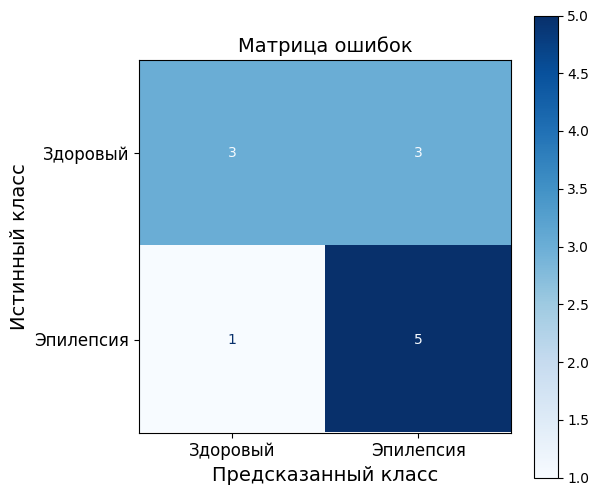

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Данные для одной модели: (истинная метка, предсказанная метка)
results = {
    "EEG_1.TRC": (1, 1),  # (файл, метка) - 1 = эпилептический
    "EEG_2.TRC": (1, 1),
    "EEG_3.TRC": (1, 1),
    "EEG_4.TRC": (1, 1),
    "EEG_6.TRC": (1, 0),
    "EEG_177.TRC": (1, 1),

    "EEG_47.TRC": (0, 0),  # 0 = здоровый
    "EEG_24.TRC": (0, 1),  # неправильно классифицированный
    "EEG_112.TRC": (0, 0),   # правильно классифицированный
    "EEG_149.TRC": (0, 1),  # неправильно классифицированный
    "EEG_109.TRC": (0, 1),
    "EEG_69.TRC": (0, 0),  # неправильно классифицированный
}

# Выделяем истинные и предсказанные метки
true_labels = [results[file][0] for file in results]  # Истинные метки
predicted_labels = [results[file][1] for file in results]  # Предсказанные метки

# Построение матрицы ошибок
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Визуализация матрицы ошибок на русском языке
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Здоровый', 'Эпилепсия'])
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')

# Задаем русские заголовки и подписи осей
plt.title("Матрица ошибок", fontsize=14)
plt.xlabel("Предсказанный класс", fontsize=14)
plt.ylabel("Истинный класс", fontsize=14)
plt.gca().set_xticklabels(['Здоровый', 'Эпилепсия'], fontsize=12)  # Подписи меток на оси X
plt.gca().set_yticklabels(['Здоровый', 'Эпилепсия'], fontsize=12)  # Подписи меток на оси Y

# Отображение графика
plt.show()
